# Detecting Cheating Buyers and Sellers Using Transaction Data

## I. Overview
An e-commerce site aims to identify buyers and sellers who engage in fraudulent activities. This issue is significant as it can reduce the site's revenue, deprive legitimate buyers and sellers of their rights to use vouchers and promotional campaigns, and create an unsafe and unfair trading environment.
## II. Types of Cheating
### 1. Creating Fake Orders to Boost Sales and Recognition

Some sellers create fake orders to artificially inflate their sales numbers and gain undeserved recognition on the platform. This practice can distort the marketplace, giving dishonest sellers an unfair advantage over genuine ones.
### 2. Fake Packages Without Goods/Without Being Delivered

Sellers may ship empty packages or fail to deliver the goods entirely after an order is placed. This not only defrauds the buyer but also damages the reputation of the e-commerce platform, leading to a loss of trust among consumers.
### 3. Stealing Money from the E-commerce Site by Creating Fake Orders

Fraudulent buyers and sellers may collaborate to create fake orders, resulting in financial losses for the e-commerce site. These fake transactions can exploit the site's payment system, leading to direct monetary theft.

### 4. Buyers Exploiting/Cheating the System to Gain More Vouchers than Permitted

Some buyers may use multiple accounts or other fraudulent methods to gain more vouchers and promotional benefits than allowed. This reduces the availability of these benefits for legitimate users and results in financial losses for the e-commerce site.
## III. Data Introduction

| Column name | Definition |
| --- | --- |
| txn_time | the Date/Time an order was created |
| txn_date | the Date an order was created |
| order_id | Order ID |
| uid | Buyer user ID |
| shop_id | Shop ID |
| shop_owner_uid | Shop owner user ID |
| gmv | Total value of an order |
| rebate | Total rebate value of an order |

## IV. Analysis
### 1. What is the most common order value range?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_csv('F:/study_data/Shopee_BI_test/Shopee_BI_test/transaction_data.csv')

In [4]:
df.head()

,txn_time,txn_date,order_id,uid,shop_id,shop_owner_uid,gmv,rebate
0,10/30/2019 13:37,10/30/2019,142008725,102161515,1005,100054430,70000,20000
1,10/30/2019 20:26,10/30/2019,142119377,102867263,10050,1792841,80000,20000
2,10/30/2019 12:22,10/30/2019,141986418,100401383,10075,100155720,125000,20000
3,10/30/2019 9:46,10/30/2019,141941958,103213155,10088,103894677,82000,20000
4,10/30/2019 21:56,10/30/2019,142139275,101003290,10142,103909421,260000,20000


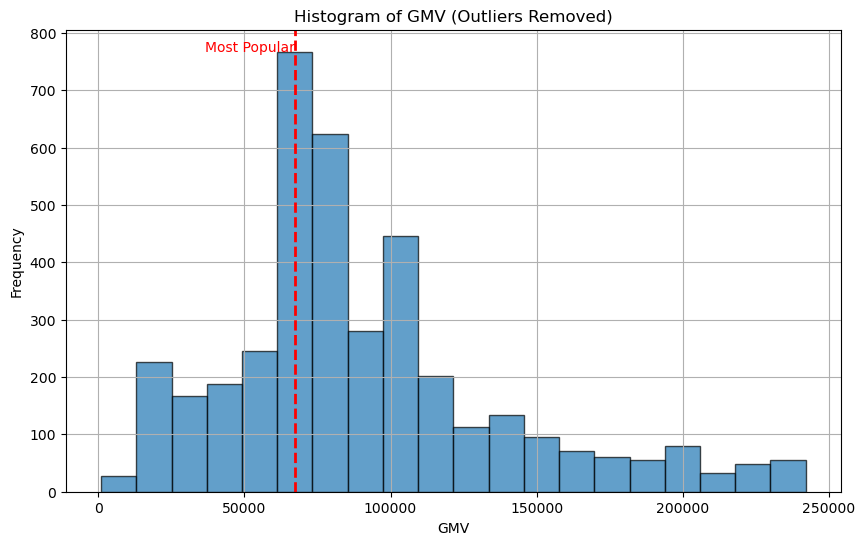

The most popular GMV range (after outlier removal) is: 61250.00 to 73300.00


In [5]:
Q1 = df['gmv'].quantile(0.25)
Q3 = df['gmv'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# remove the outliers
df_filtered = df[(df['gmv'] >= 1000) & (df['gmv'] <= upper_bound)]

plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_filtered['gmv'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('GMV')
plt.ylabel('Frequency')
plt.title('Histogram of GMV (Outliers Removed)')
plt.grid(True)

# Find the bin with the highest frequency
max_bin_index = np.argmax(n)
most_popular_range = (bins[max_bin_index], bins[max_bin_index + 1])
most_popular_bin_center = (most_popular_range[0] + most_popular_range[1]) / 2

# Add a red, dashed vertical line in the middle of the most popular bin
plt.axvline(most_popular_bin_center, color='red', linestyle='--', linewidth=2)
plt.text(most_popular_bin_center, max(n), 'Most Popular', color='red', ha='right')

plt.show()
print(f"The most popular GMV range (after outlier removal) is: {most_popular_range[0]:.2f} to {most_popular_range[1]:.2f}")

### 2. Identify the sellers most likely to have engaged in fraudulent activities

Using this data, it is possible to identify possible fradulent sellers by identifying shops that are having a large number of suspicious orders. \
We noticed strange pattern in the GMV column, which sometimes go below 1K VND although it is not possible to have an order below 1K in Shopee e-commerce site. This might be a cheating behavior where sellers try to boost their sales by making fake orders. Therefore we are going to look closely at these orders to have some insights about who is exploiting the system (seller side).

In [6]:
df.describe()

,order_id,uid,shop_id,shop_owner_uid,gmv,rebate
count,4611.00,4611.00,4611.00,4611.00,4611.00,4611.00
mean,142459452.63,89407785.15,11012.24,82374120.97,138985.28,16813.51
std,282885.29,33332276.69,9006.85,40535045.40,193990.41,6520.51
min,141901047.00,1002600.00,136.00,1000025.00,1.00,0.00
25%,142232061.00,100441381.50,5643.00,100305004.00,70000.00,19500.00
50%,142485396.00,101495141.00,8433.00,102817559.00,84926.00,20000.00
75%,142723326.50,103266260.00,10873.00,103489596.00,139000.00,20000.00
max,142871368.00,104103057.00,30223.00,104095417.00,3750000.00,20000.00


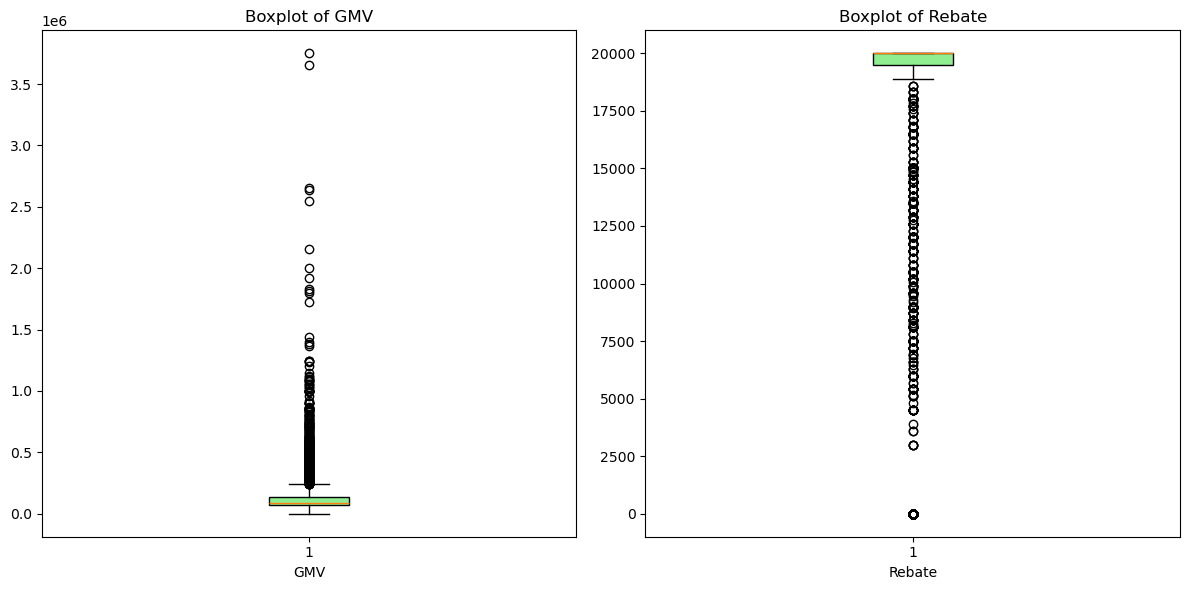

In [7]:
plt.figure(figsize=(12, 6))

# Create boxplot for 'gmv'
plt.subplot(1, 2, 1)
plt.boxplot(df['gmv'], patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('Boxplot of GMV')
plt.xlabel('GMV')

# Create boxplot for 'rebate'
plt.subplot(1, 2, 2)
plt.boxplot(df['rebate'], patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('Boxplot of Rebate')
plt.xlabel('Rebate')

# Show the plots
plt.tight_layout()
plt.show()

In [8]:
#find out which user id has the most orders with gmv smaller than or equal to 1000
#users can use these orders to boost a shop's number of orders
temp = df[df['gmv']<=1000].groupby('uid').count().sort_values('gmv',ascending = False)
uid_lst = temp[temp['rebate']>temp['rebate'].median()].index
res = df[df['uid'].isin(uid_lst)].groupby(['uid','txn_date']).count()
res=res.reindex(temp.index,level = 'uid')



In [9]:
uid_lst = res.reset_index().sort_values('rebate',ascending = False).drop_duplicates(subset = 'uid',keep = 'first')[['uid','rebate']].rename(columns = {'rebate':'count'})['uid']

In [10]:
temp = df[df['uid'].isin(uid_lst)].groupby(['uid','shop_owner_uid']).count().reset_index().sort_values('gmv',ascending = False)
temp = temp[temp['rebate']>1]
temp.sort_values(['rebate','shop_owner_uid','uid'],ascending = False, inplace = True)

In [11]:
print('Cheating sellers and their associations (buyer accounts that help them cheat)')
temp[['uid','shop_owner_uid','rebate']].rename(columns = {'uid': 'Buyer uid',
                                                          'shop_owner_uid': 'Seller uid',
                                                          'rebate':'times with recurring suspicious order (orders <1000)'})

Cheating sellers and their associations (buyer accounts that help them cheat)


,Buyer uid,Seller uid,times with recurring suspicious order (orders <1000)
77,101065061,1006513,5
61,100605978,104080159,4
27,100205391,1011881,4
21,100205391,1007436,4
62,100605978,104081012,3
56,100605978,103932347,3
25,100205391,1011823,3
23,100205391,1011329,3
20,100048472,1005623,3
36,100352740,104095417,2


### 2. Identify the buyers most likely to engage in fraudulent activities.

Next, for a campaign a buyer usually has a limitted amount of rebate vouchers. Therefore, if a person had claimed rebate voucher for a large amount of times it's actually a suspicious behavior that can be flagged as cheating. We are going to identify buyers that used several rebate vouchers per day.\
On average, a customer uses 1.13 rebate voucher daily. However, we can see that the maximum of vouchers for some users in a single day is 10. There is something very strange about this. This can be a sign that the buyer is exploiting the system to gain more vouchers.\
We are going to identify these buyers.

In [12]:
#statistics on number of vouchers claimed daily
temp =df[df['rebate']>0].groupby(['txn_date','uid']).count().sort_values('rebate',ascending = False).rename(columns = {'rebate':'Count'})
temp['Count'].describe()

count   3639.00
mean       1.13
std        0.64
min        1.00
25%        1.00
50%        1.00
75%        1.00
max       10.00
Name: Count, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x2c6bb61a720>,
 'caps': [<matplotlib.lines.Line2D at 0x2c6bb61acc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2c6bb61a4e0>],
 'medians': [<matplotlib.lines.Line2D at 0x2c6bb61b260>],
 'fliers': [<matplotlib.lines.Line2D at 0x2c6bb61b4d0>],
 'means': []}

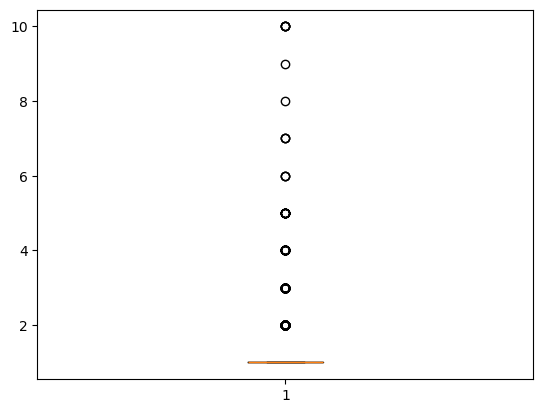

In [13]:
plt.boxplot(temp['Count'])

Looking at this boxplot, even claiming 2 vouchers daily is considered an outlier. 

In [14]:
#How many customers claim 1/2/... vouchers daily?

data =Counter(temp['Count'])
total = sum(data.values())
percentage_ratios = {key: (value / total) * 100 for key, value in data.items()}

print('% of people claiming X vouchers daily')
for key, value in percentage_ratios.items():
    print(f"{key}: {value:.2f}%")

% of people claiming X vouchers daily
10: 0.14%
9: 0.03%
8: 0.03%
7: 0.08%
6: 0.08%
5: 0.36%
4: 0.85%
3: 1.68%
2: 3.41%
1: 93.35%


In [15]:
temp =temp.reset_index().drop_duplicates(subset = 'uid',keep = 'first')
print('Possible buyers who cheated: ')
temp[temp['Count']>5][['txn_date','uid','Count']].rename(columns = {'Count':'Number of vouchers used'})

Possible buyers who cheated: 


,txn_date,uid,Number of vouchers used
0,10/31/2019,103868446,10
1,11/1/2019,103653018,10
2,11/1/2019,103653392,10
3,11/1/2019,103667901,10
4,11/1/2019,103023839,10
5,11/1/2019,103366324,9
6,11/2/2019,103044781,8
7,11/2/2019,103682325,7
8,11/2/2019,103044677,7
9,11/1/2019,103698457,7
